# Biochar credits crosswalk notebook (7 standards)

Modeling sandbox to compare how many credits would be minted for the *same theoretical biochar project* under:
- Global Biochar C-Sink (Carbon Standards International)
- Global Artisan C-Sink (Carbon Standards International)
- Riverse / Rainbow Standard (BiCRS – Biochar to soils)
- Puro.earth (Biochar Methodology)
- Isometric (Biochar Protocol)
- Climate Action Reserve (U.S. & Canada Biochar Protocol)
- Verra VCS (VM0044)

Notes:
- Standards evolve; this notebook is transparent and modular.
- Where a standard relies on external tools (e.g., Ecoinvent or proprietary calculators), you can paste those emissions outputs here.


## 0) Setup

In [33]:
\
import math
from dataclasses import dataclass, asdict
from typing import Optional, Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def tCO2_from_tC(tC: float) -> float:
    return tC * (44/12)

def dry_mass_from_wet(wet_t: float, moisture_frac: float) -> float:
    # moisture_frac = mass water / total wet mass (0-1)
    return wet_t * (1 - moisture_frac)

colors = plt.get_cmap("tab10").colors
i = 0

## 1) Define project inputs

In [34]:
\
@dataclass
class ProjectInputs:
    # Biochar quantities
    biochar_wet_t: float                 # tonnes wet biochar delivered/applied in the period
    biochar_moisture_frac: float         # 0-1
    biochar_Corg_frac: float             # 0-1 (organic carbon fraction on dry basis)
    biochar_HCorg_molar: float           # molar H/Corg

    # Context for soil applications
    soil_temp_C: float                   # mean annual soil temp at application site

    # Emissions (enter if known; else keep 0 to compare storage-side)
    E_biomass_tCO2e: float = 0.0
    E_production_tCO2e: float = 0.0
    E_transport_tCO2e: float = 0.0
    E_use_tCO2e: float = 0.0
    E_leakage_tCO2e: float = 0.0
    C_baseline_tCO2e: float = 0.0

    # Optional: random reflectance pathway inputs
    inertinite_fraction: Optional[float] = None  # fraction (0-1) of residual C with R0 >= 2%
    residual_C_fraction: Optional[float] = None  # residual organic carbon fraction (0-1)

inputs = ProjectInputs(
    biochar_wet_t=42.8,
    biochar_moisture_frac=0.15,
    biochar_Corg_frac=0.75,
    biochar_HCorg_molar=0.30,
    soil_temp_C=15.0,
    # emissions placeholders (edit)
    E_biomass_tCO2e=0.0,
    E_production_tCO2e=0.0,
    E_transport_tCO2e=0.0,
    E_use_tCO2e=0.0,
    E_leakage_tCO2e=0.0,
    C_baseline_tCO2e=0.0,
    # optional for R0 pathway
    inertinite_fraction=0.72,
    residual_C_fraction=0.95,
)

inputs


ProjectInputs(biochar_wet_t=42.8, biochar_moisture_frac=0.15, biochar_Corg_frac=0.75, biochar_HCorg_molar=0.3, soil_temp_C=15.0, E_biomass_tCO2e=0.0, E_production_tCO2e=0.0, E_transport_tCO2e=0.0, E_use_tCO2e=0.0, E_leakage_tCO2e=0.0, C_baseline_tCO2e=0.0, inertinite_fraction=0.72, residual_C_fraction=0.95)

## 2) Shared physical quantities

In [35]:
\
def shared_physical(inputs: ProjectInputs) -> Dict[str, float]:
    dry_t = dry_mass_from_wet(inputs.biochar_wet_t, inputs.biochar_moisture_frac)
    tC0 = dry_t * inputs.biochar_Corg_frac
    tCO2e0 = tCO2_from_tC(tC0)
    return {
        "biochar_dry_t": dry_t,
        "Corg_tC": tC0,
        "Corg_tCO2e": tCO2e0
    }

shared_physical(inputs)


{'biochar_dry_t': 36.379999999999995,
 'Corg_tC': 27.284999999999997,
 'Corg_tCO2e': 100.04499999999999}

## 3) Standard calculators

In [36]:
\
# --------------------------
# 3.1 CSI: Global Artisan C-Sink
# --------------------------
def calc_csi_artisan(inputs: ProjectInputs,
                     safety_margin: float = 0.02, # 20kg/tonne
                     persistence_100y: float = 0.74) -> Dict[str, Any]:
    '''
    Worked example in CSI Global Artisan C-Sink:
      credits = dry_mass * Corg * (1 - 3% margin) * 44/12 * 0.74 persistence (soil).
    '''
    dry_t = dry_mass_from_wet(inputs.biochar_wet_t, inputs.biochar_moisture_frac)
    csink_potential = dry_t * inputs.biochar_Corg_frac * (1 - safety_margin) * (44/12)
    credits = csink_potential * persistence_100y
    return {
        "credits_tCO2e": credits/dry_t,
        "csink_potential_tCO2e": csink_potential,
        "assumptions": {"safety_margin": safety_margin, "persistence_100y": persistence_100y},
        "notes": "Artisan: dry_mass*Corg*(1-3%)*44/12*0.74"
    }

# --------------------------
# 3.2 CSI: Global Biochar C-Sink (soil; simplified issuance proxy)
# --------------------------

def csi_global_safety_margin_tCO2e(inputs: ProjectInputs) -> float:
    # 20 kg CO2e per ton of biochar (dry matter) = 0.020 tCO2e / t DM
    dry_t = dry_mass_from_wet(inputs.biochar_wet_t, inputs.biochar_moisture_frac)
    return 0.020 * dry_t

def csi_cremain_soil_tC(inputs: ProjectInputs, years: np.ndarray) -> np.ndarray:
    """
    CSI Global Biochar C-Sink Standard v3.2 soil decay:
      - Eq. 4 if H/Corg < 0.40  (PAC 75% + SPC 25%)
      - Eq. 5 if H/Corg >= 0.40 (SPC 100%)
    Returns remaining carbon in tonnes C for each year in `years`.
    """
    dry_t = dry_mass_from_wet(inputs.biochar_wet_t, inputs.biochar_moisture_frac)
    MBC = dry_t
    Ccont = inputs.biochar_Corg_frac  # fraction of dry mass

    y = np.asarray(years, dtype=float)

    # two-term exponential used in both equations
    spc_term = (0.1787 * np.exp(-0.5337 * y) + 0.8237 * np.exp(-0.00997 * y))

    #plt.plot(y)

    if inputs.biochar_HCorg_molar < 0.40:
        # Eq. 4: Cremain = MBC*Ccont*(0.75 + 0.25*spc_term)
        return MBC * Ccont * (0.75 + 0.25 * spc_term)
    else:
        # Eq. 5: Cremain = MBC*Ccont*(spc_term)
        return MBC * Ccont * spc_term


def csi_c_sink_H(inputs: ProjectInputs, H: int = 100, plot = 'yes') -> dict:
    """
    CSI Eq. 3: C-Sink_H = (sum_{year=1..H} Cremain(year)) / H
    Expressed as annualized CO2e (t aCO2e).
    """
    years = np.arange(1, H + 1)
    cremain_tC = csi_cremain_soil_tC(inputs, years)
    avg_annual_tC = cremain_tC.sum() / H
    c_sink_H_taCO2e = avg_annual_tC * (44/12)
    dry_t = dry_mass_from_wet(inputs.biochar_wet_t, inputs.biochar_moisture_frac)

    # also expose initial carbon and a non-CSI "total average stored CO2e over H"
    C0_tC = shared_physical(inputs)["Corg_tC"]
    C0_tCO2e = shared_physical(inputs)["Corg_tCO2e"]
    avg_annual_tCO2e = c_sink_H_taCO2e  # same, but clearer naming

    if plot == 'yes':
        #plotting 
        years_max = H+200
        y_units = "tCO2e"
        
        years = np.arange(0, years_max + 1)  # include year 0
        # CSI equations typically start at year 1; define year 0 as initial carbon
        C0_tC = shared_physical(inputs)["Corg_tC"]
        cremain_tC = csi_cremain_soil_tC(inputs, np.maximum(years, 1))
        cremain_tC[0] = C0_tC
        
        if y_units == "tCO2e":
            yvals = cremain_tC * (44/12)
            ylabel = "Remaining carbon (tCO₂e)"
        else:
            yvals = cremain_tC
            ylabel = "Remaining carbon (tC)"
    
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
        ax.plot(years, yvals)
        ax.axvline(H, linestyle="--")
        ax.set_xlabel("Years since application")
        ax.set_ylabel(ylabel)
    
        regime = "PAC75%+SPC25% (H/Corg < 0.40)" if inputs.biochar_HCorg_molar < 0.40 else "SPC100% (H/Corg ≥ 0.40)"
        ax.set_title(f"CSI Global soil Cremain(t) — {regime}")
    
        plt.show()


    return {
        "H_years": H,
        "C0_tCO2e": C0_tCO2e,
        "C_Sink_H_taCO2e": c_sink_H_taCO2e,  # annualized
        "credits_tCO2e":c_sink_H_taCO2e/dry_t,
        "avg_annual_tC": avg_annual_tC,
        "notes": "CSI Global soil: C-Sink_H is an annualized CO2e metric computed from yearly Cremain."
    }    

# --------------------------
# 3.3 Riverse / Rainbow (BiCRS - Biochar to soils) Approach 1 (100y, H/Corg)
# --------------------------
def _rainbow_coeffs(soil_temp_C: float):
    if soil_temp_C < 7.49:
        return 1.13, 0.46
    if soil_temp_C < 12.49:
        return 1.10, 0.59
    if soil_temp_C < 17.49:
        return 1.04, 0.64
    if soil_temp_C < 22.49:
        return 1.01, 0.65
    return 0.98, 0.66

def calc_riverse_rainbow_100y(inputs: ProjectInputs) -> Dict[str, Any]:
    '''
    Rainbow biochar-to-soils module:
      Fperm100 = c - m*H/Corg
      RP_storage100 = Fperm100*Corg*Abiochar*(1-M%)*44/12
    Here we subtract user-provided emissions totals as a convenience.
    '''
    c, m = _rainbow_coeffs(inputs.soil_temp_C)
    Fperm = max(0.0, min(1.0, c - m * inputs.biochar_HCorg_molar))
    dry_t = dry_mass_from_wet(inputs.biochar_wet_t, inputs.biochar_moisture_frac)
    stored = Fperm * inputs.biochar_Corg_frac * dry_t * (44/12)
    net = stored - (inputs.E_biomass_tCO2e + inputs.E_production_tCO2e + inputs.E_transport_tCO2e + inputs.E_use_tCO2e + inputs.E_leakage_tCO2e)
    return {"credits_tCO2e": net/dry_t, "storage_component_tCO2e": stored, "Fperm100": Fperm, "coeffs": {"c": c, "m": m}}

# --------------------------
# 3.4 Puro.earth Biochar (Edition 2025 v2)
# --------------------------
def calc_puro_2025(inputs: ProjectInputs, plot = 'yes') -> Dict[str, Any]:
    '''
    Puro 2025:
      CORCs = Cstored - Cbaseline - Closs - Eproject - Eleakage
      Cstored = Qbiochar*Corg*44/12
      Closs = Cstored*(100-PF)/100
      PF = M - a*H/Corg, where M,a depend on soil temperature (rounded up, min 7C)
    This notebook includes M,a lookups for Ts=7..17C (extend as needed).
    '''
    M_lookup = {
    7: 96.59, 8: 95.98, 9: 95.36, 10: 94.73, 11: 94.10, 12: 93.50, 13: 92.92, 14: 92.38,
    15: 91.87, 16: 91.40, 17: 90.96, 18: 90.57, 19: 90.20, 20: 89.87, 21: 89.57, 22: 89.29,
    23: 89.03, 24: 88.79, 25: 88.57, 26: 88.37, 27: 88.18, 28: 87.99, 29: 87.82, 30: 87.66,
    31: 87.50, 32: 87.34, 33: 87.19, 34: 87.04, 35: 86.90, 36: 86.75, 37: 86.61, 38: 86.47,
    39: 86.33, 40: 86.19
    }

    a_lookup = {
    7: 11.28, 8: 13.44, 9: 15.66, 10: 17.92, 11: 20.15, 12: 22.31, 13: 24.38, 14: 26.33,
    15: 28.16, 16: 29.84, 17: 31.39, 18: 32.81, 19: 34.11, 20: 35.29, 21: 36.36, 22: 37.35,
    23: 38.26, 24: 39.09, 25: 39.87, 26: 40.59, 27: 41.27, 28: 41.91, 29: 42.52, 30: 43.10,
    31: 43.67, 32: 44.21, 33: 44.74, 34: 45.26, 35: 45.77, 36: 46.27, 37: 46.77, 38: 47.27,
    39: 47.76, 40: 48.25
    }
    
    Ts = max(7, math.ceil(inputs.soil_temp_C))   # min 7°C; round up
    Ts = min(Ts, 40)                             # table provided to 40°C
    M = M_lookup[Ts]
    a = a_lookup[Ts]
    PF_percent = max(0.0, min(100.0, M - a * inputs.biochar_HCorg_molar))
    
    dry_t = dry_mass_from_wet(inputs.biochar_wet_t, inputs.biochar_moisture_frac)
    Cstored = dry_t * inputs.biochar_Corg_frac * (44/12)
    Closs = Cstored * (100 - PF_percent) / 100.0
    Eproject = inputs.E_biomass_tCO2e + inputs.E_production_tCO2e + inputs.E_transport_tCO2e + inputs.E_use_tCO2e
    Eleakage = inputs.E_leakage_tCO2e
    CORCs = Cstored - inputs.C_baseline_tCO2e - Closs - Eproject - Eleakage

    if plot == 'yes':
        plt.plot(np.linspace(0,1,100), M-a*np.linspace(0,1,100), label=fr'T$_s$ = {Ts}°C', color = colors[i]) # provide linear relationship
        plt.xlabel('H/C$_{org}$')
        plt.ylabel('Permanent Fraction [%]')
        plt.title('Puro Regression')
        plt.legend()

    return {"credits_tCO2e": CORCs/dry_t, "Cstored_tCO2e": Cstored, "Closs_tCO2e": Closs, "PF_percent": PF_percent, "Ts_used_C": Ts}

# --------------------------
# 3.5 Isometric (proxy)
# --------------------------
def calc_isometric(inputs: ProjectInputs, durability_years: int = 200) -> Dict[str, Any]:
    '''
    Isometric describes:
      - 200y durability: H/Corganic + projected decay curves
      - 1000y durability: Random Reflectance; inertinite fraction credited
    We implement transparent proxies:
      - 200y: Woolf-style Fperm (placeholder)
      - 1000y: dry_mass*Corg*residual_C*inertinite_fraction*44/12
    '''
    dry_t = dry_mass_from_wet(inputs.biochar_wet_t, inputs.biochar_moisture_frac)
    if durability_years == 1000:
        if inputs.inertinite_fraction is None or inputs.residual_C_fraction is None:
            raise ValueError("Need inertinite_fraction and residual_C_fraction for 1000-year pathway.")
        stored = dry_t * inputs.biochar_Corg_frac * inputs.residual_C_fraction * inputs.inertinite_fraction * (44/12)
    else:
        c, m = _rainbow_coeffs(inputs.soil_temp_C)
        Fperm = max(0.0, min(1.0, c - m * inputs.biochar_HCorg_molar))
        stored = Fperm * inputs.biochar_Corg_frac * dry_t * (44/12)
    net = stored - (inputs.E_biomass_tCO2e + inputs.E_production_tCO2e + inputs.E_transport_tCO2e + inputs.E_use_tCO2e + inputs.E_leakage_tCO2e)
    return {"credits_tCO2e": net/dry_t, "storage_component_tCO2e": stored, "durability_years": durability_years}

# --------------------------
# 3.6 CAR (simplified single biochar type/end use)
# --------------------------
def calc_car(inputs: ProjectInputs, PEU: Optional[float] = None) -> Dict[str, Any]:
    '''
    CAR Eq 5.12 (simplified single biochar type/end use):
      PC = Mb * DM * OCb * PEU * 3.67
    If PEU is not provided, we approximate PEU with Woolf-style Fperm (placeholder).
    '''
    dry_t = dry_mass_from_wet(inputs.biochar_wet_t, inputs.biochar_moisture_frac)  # Mb*DM
    OCb = inputs.biochar_Corg_frac
    if PEU is None:
        c, m = _rainbow_coeffs(inputs.soil_temp_C)
        PEU = max(0.0, min(1.0, c - m * inputs.biochar_HCorg_molar))
    PC = dry_t * OCb * PEU * (44/12)
    net = PC - (inputs.E_biomass_tCO2e + inputs.E_production_tCO2e + inputs.E_transport_tCO2e + inputs.E_use_tCO2e + inputs.E_leakage_tCO2e)
    return {"credits_tCO2e": net/dry_t, "storage_component_tCO2e": PC, "PEU": PEU}

# --------------------------
# 3.7 Verra VM0044 (simplified)
# --------------------------
def calc_verra_vm0044(inputs: ProjectInputs, PRde: Optional[float] = None) -> Dict[str, Any]:
    '''
    VM0044 v1.2 (simplified):
      CC = M * FCp * PRde
      ERPS = (CC*44/12) - PE_production
    Full net includes baseline, leakage, and reversal risk mitigation.
    '''
    dry_t = dry_mass_from_wet(inputs.biochar_wet_t, inputs.biochar_moisture_frac)
    FCp = inputs.biochar_Corg_frac
    if PRde is None:
        PRde = 0.80  # placeholder (medium-temp default in VM0044 Table 3)
    CC = dry_t * FCp * PRde  # tonnes C
    ERPS = tCO2_from_tC(CC) - inputs.E_production_tCO2e
    net = ERPS - (inputs.E_biomass_tCO2e + inputs.E_transport_tCO2e + inputs.E_use_tCO2e + inputs.E_leakage_tCO2e)
    return {"credits_tCO2e": net/dry_t, "ERPS_tCO2e": ERPS, "PRde": PRde}


## 4) Run and compare

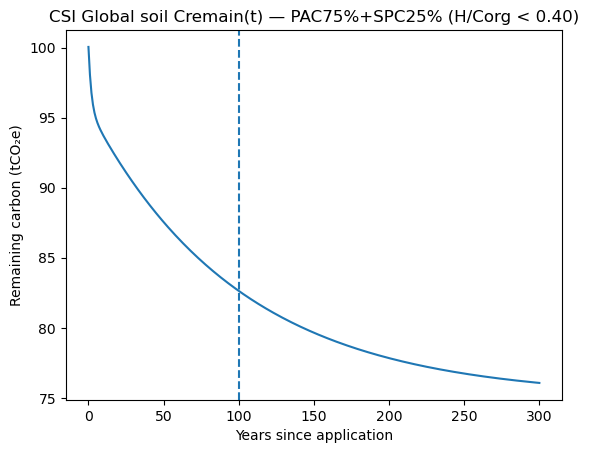

,standard,credits_tCO2e
0,CSI Global Biochar C-Sink (proxy),2.420874
2,"Riverse / Rainbow (100y, H/C)",2.332000
4,Isometric (200y proxy),2.332000
6,CAR (simplified),2.332000
3,Puro.earth (2025 v2),2.294105
7,Verra VM0044 (simplified),2.200000
1,CSI Global Artisan C-Sink,1.994300
5,Isometric (1000y proxy),1.881000


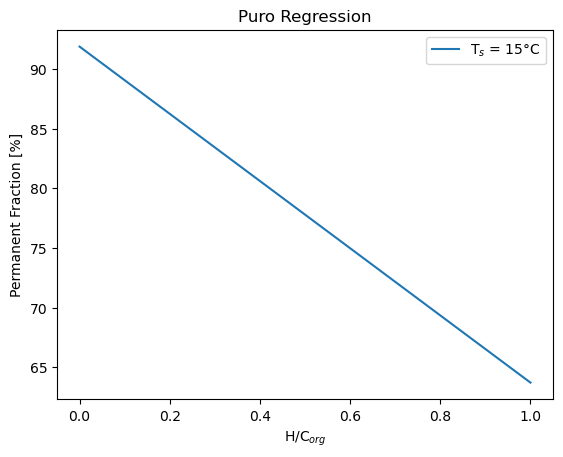

In [37]:
\
results = [
    ("CSI Global Biochar C-Sink (proxy)", csi_c_sink_H(inputs,H=100)),
    ("CSI Global Artisan C-Sink", calc_csi_artisan(inputs)),
    ("Riverse / Rainbow (100y, H/C)", calc_riverse_rainbow_100y(inputs)),
    ("Puro.earth (2025 v2)", calc_puro_2025(inputs, plot = 'yes')),
    ("Isometric (200y proxy)", calc_isometric(inputs, durability_years=200)),
    ("Isometric (1000y proxy)", calc_isometric(inputs, durability_years=1000)),
    ("CAR (simplified)", calc_car(inputs)),
    ("Verra VM0044 (simplified)", calc_verra_vm0044(inputs)),
]

df = pd.DataFrame([{"standard": n, **o} for n,o in results])
df[["standard","credits_tCO2e"]].sort_values("credits_tCO2e", ascending=False)


## 5) Sensitivity sweep (H/Corg and soil temperature)

In [38]:
\
import numpy as np

def sweep(hc_values=np.linspace(0,0.7,20), temps=np.linspace(0,25,20)):
    rows = []
    base = asdict(inputs)
    for Ts in temps:
        for hc in hc_values:
            base["soil_temp_C"] = float(Ts)
            base["biochar_HCorg_molar"] = float(hc)
            inp = ProjectInputs(**base)
            rows.append({
                "soil_temp_C": Ts,
                "H_Corg": hc,
                "Puro_CORCs": calc_puro_2025(inp, plot = 'no')["credits_tCO2e"],
                "Rainbow_100y": calc_riverse_rainbow_100y(inp)["credits_tCO2e"],
                "CAR_storage": calc_car(inp)["storage_component_tCO2e"],
                "csi_c_sink_H": csi_c_sink_H(inp, H=100, plot = 'no')["credits_tCO2e"],
                'Isometric_200y': calc_isometric(inp, 100)["credits_tCO2e"]
            })
    return pd.DataFrame(rows)

df_sweep = sweep()
df_sweep.head()


,soil_temp_C,H_Corg,Puro_CORCs,Rainbow_100y,CAR_storage,csi_c_sink_H,Isometric_200y
0,0.0,0.000000,2.656225,2.75,100.045,2.420874,2.75
1,0.0,0.036842,2.644797,2.75,100.045,2.420874,2.75
2,0.0,0.073684,2.633368,2.75,100.045,2.420874,2.75
3,0.0,0.110526,2.621940,2.75,100.045,2.420874,2.75
4,0.0,0.147368,2.610511,2.75,100.045,2.420874,2.75


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Create meshgrid
H = np.sort(df_sweep["H_Corg"].unique())
T = np.sort(df_sweep["soil_temp_C"].unique())
H_grid, T_grid = np.meshgrid(H, T)

def grid_from_df(df, value_col):
    Z = np.empty_like(H_grid, dtype=float)
    for i, Ts in enumerate(T):
        for j, hc in enumerate(H):
            Z[i, j] = df.loc[
                (df["soil_temp_C"] == Ts) &
                (df["H_Corg"] == hc),
                value_col
            ].values[0]
    return Z


Text(0.5, 0.92, 'Puro.earth – CORCs')

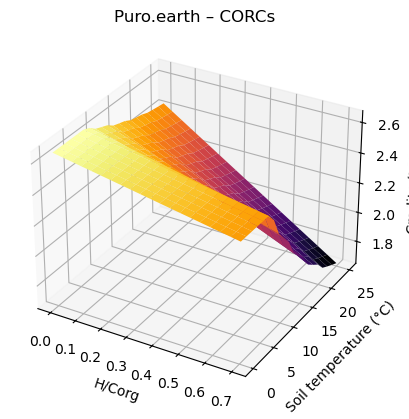

In [40]:
Z_puro = grid_from_df(df_sweep, "Puro_CORCs")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    H_grid,
    T_grid,
    Z_puro, cmap = 'inferno'
)

ax.set_xlabel("H/Corg")
ax.set_ylabel("Soil temperature (°C)")
ax.set_zlabel("Credits (tCO₂e)")
ax.set_title("Puro.earth – CORCs")




Text(0.5, 0.92, 'Rainbow / Riverse – 100y Storage')

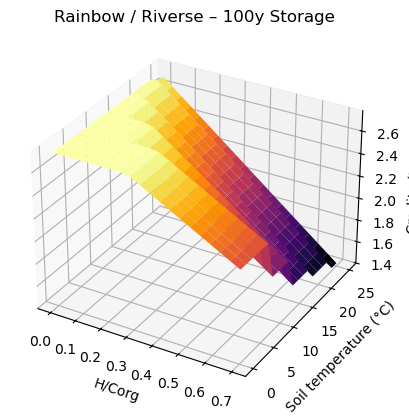

In [41]:
Z_rainbow = grid_from_df(df_sweep, "Rainbow_100y")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    H_grid,
    T_grid,
    Z_rainbow, cmap = 'inferno'
)

ax.set_xlabel("H/Corg")
ax.set_ylabel("Soil temperature (°C)")
ax.set_zlabel("Credits (tCO₂e)")
ax.set_title("Rainbow / Riverse – 100y Storage")





Text(0.5, 0.92, 'Isometric — 200y Storage')

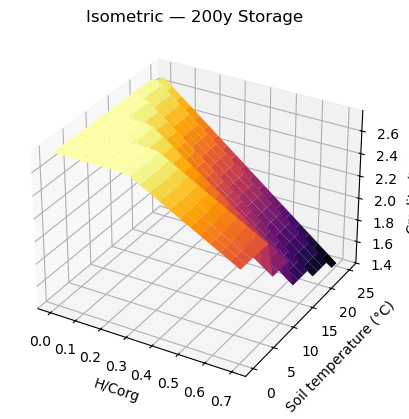

In [42]:
Z_isometric = grid_from_df(df_sweep, "Isometric_200y")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    H_grid,
    T_grid,
    Z_isometric, cmap = 'inferno'
)


ax.set_xlabel("H/Corg")
ax.set_ylabel("Soil temperature (°C)")
ax.set_zlabel("Credits (tCO₂e)")
ax.set_title("Isometric — 200y Storage")


Text(0.5, 0.92, 'Isometric — Puro')

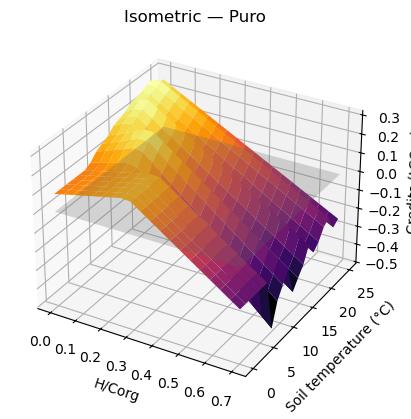

In [43]:
Z_difference = Z_isometric-Z_puro


fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")


# Zero plane
Z0 = np.zeros_like(Z_difference)
ax.plot_surface(H_grid, T_grid, Z0, alpha=0.25,color = 'gray')

ax.plot_surface(
    H_grid,
    T_grid,
    Z_difference, cmap = 'inferno'
)



ax.set_xlabel("H/Corg")
ax.set_ylabel("Soil temperature (°C)")
ax.set_zlabel("Credits (tCO₂e)")
ax.set_title("Isometric — Puro")


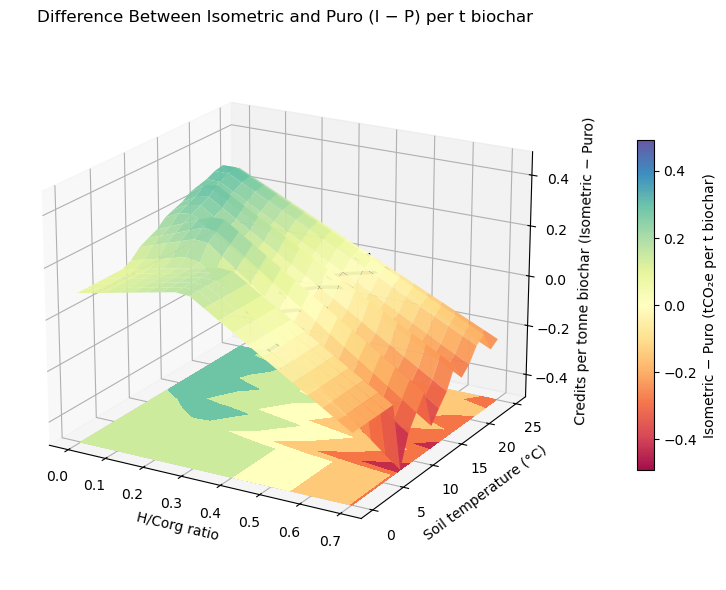

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Assume you already have:
# H_grid, T_grid, Z_diff  (Z_diff = Iso - Puro, per t biochar)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

# 1) symmetric range around 0 (makes comparisons cleaner)
zmax = np.nanmax(np.abs(Z_difference))
zmin = -zmax

# 2) choose banded levels like your example legend
levels = np.linspace(zmin, zmax, 8)   # change 8 -> #bands+1

# 3) diverging colormap centered at 0
norm = colors.TwoSlopeNorm(vmin=zmin, vcenter=0.0, vmax=zmax)
cmap = plt.get_cmap("Spectral")  # banded look; try "coolwarm" too

# 4) plot the surface
surf = ax.plot_surface(
    H_grid, T_grid, Z_difference,
    cmap=cmap,
    norm=norm,
    linewidth=0,
    antialiased=True,
    alpha=0.95
)

# 5) "below-axis" filled projection plane
# Put the contourf on a plane at z = zmin (below everything)
ax.contourf(
    H_grid, T_grid, Z_difference,
    zdir="z",
    offset=zmin,
    levels=levels,
    cmap=cmap,
    norm=norm
)

# 6) optional: draw the zero line on that plane (super readable)
ax.contour(
    H_grid, T_grid, Z_difference,
    zdir="z",
    offset=zmin,
    levels=[0],
    colors="k",
    linewidths=2
)

# ---- draw z = 0 line ON the surface ----
ax.contour(
    H_grid, T_grid, Z_difference,
    levels=[0],          # exactly z = 0
    colors="k",
    linewidths=2.5
)

# # 7) optional: zero plane wireframe (subtle)
# ax.plot_wireframe(
#     H_grid, T_grid, np.zeros_like(Z_difference),
#     rstride=2, cstride=2,
#     linewidth=0.6,
#     alpha=0.35
# )

# labels / limits
ax.set_zlim(zmin, zmax)
ax.set_xlabel("H/Corg ratio")
ax.set_ylabel("Soil temperature (°C)")
ax.set_zlabel("Credits per tonne biochar (Isometric − Puro)")

ax.set_title("Difference Between Isometric and Puro (I − P) per t biochar")

# viewing angle similar to your example
ax.view_init(elev=20, azim=-60)
ax.view_init(elev=20, azim=-60)

# colorbar OR legend
cbar = fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.08)
cbar.set_label("Isometric − Puro (tCO₂e per t biochar)")

plt.tight_layout()
plt.show()
